In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
from feature_engine.selection import DropFeatures
from feature_engine.creation import MathFeatures

# from sklearn.compose import TransformedTargetRegressor
# from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from tqdm.auto import tqdm

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

In [2]:
train = pd.read_parquet("train_temporal_regression.parquet.gz")
test = pd.read_parquet("test_temporal_regression.parquet.gz")

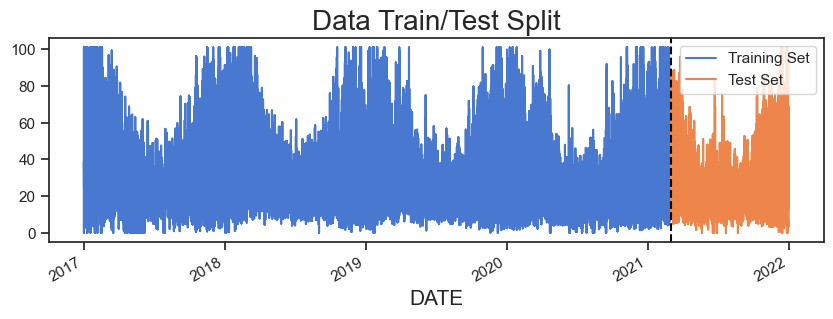

In [3]:
#Visualizing how the data is split
cut_off_date="2021-03-01"

fig, ax = plt.subplots(figsize=(10, 3))

train.plot(y='CAQI_idx', ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(y='CAQI_idx', ax=ax, label='Test Set')

ax.axvline(cut_off_date, color='black', ls='--')

ax.legend(['Training Set', 'Test Set'])
plt.show();

In [4]:
X_train = train.drop('CAQI_idx', axis=1)
y_train = train['CAQI_idx']

X_test = test.drop('CAQI_idx', axis=1)
y_test = test['CAQI_idx']

In [5]:
#Combining Static cols together and putting them in a pipeline
combine1 = MathFeatures(
    variables = [col for col in X_train.columns if col.startswith("emission of particulates")],
    func='sum',
    new_variables_names=["emission of particulates"],
    drop_original=True
)

combine2 = MathFeatures(
    variables = [col for col in X_train.columns if col.startswith("emission of pollutant gases")],
    func='sum',
    new_variables_names=["emission of pollutant gases"],
    drop_original=True
)

combine3 = MathFeatures(
    variables = [col for col in X_train.columns if col.startswith("total vehicles")],
    func='sum',
    new_variables_names=["total vehicles"],
    drop_original=True
)

combine4 = MathFeatures(
    variables = [col for col in X_train.columns if col.startswith("vehicles by type and fuel")],
    func='sum',
    new_variables_names=["vehicles by type and fuel"],
    drop_original=True
)

combine5 = MathFeatures(
    variables = [col for col in X_train.columns if col.startswith("crop production")],
    func='sum',
    new_variables_names=["crop production"],
    drop_original=True
)


combine6 = MathFeatures(
    variables = [c for c in [col for col in X_train.columns if "equipment" in col] if "low" in c],
    func='sum',
    new_variables_names=["air pollution reduction systems - equipment - efficiency low"],
    drop_original=True
)

combine7 = MathFeatures(
    variables = [c for c in [col for col in X_train.columns if "equipment" in col] if "moderate" in c],
    func='sum',
    new_variables_names=["air pollution reduction systems - equipment - efficiency moderate"],
    drop_original=True
)

combine8 = MathFeatures(
    variables = [c for c in [col for col in X_train.columns if "equipment" in col] if "high" in c],
    func='sum',
    new_variables_names=["air pollution reduction systems - equipment - efficiency high"],
    drop_original=True
)

combine9 = MathFeatures(
    variables = [c for c in [col for col in X_train.columns if "waste gas flow" in col] if " low" in c],
    func='sum',
    new_variables_names=["air pollution reduction systems - waste gas flow - efficiency low"],
    drop_original=True
)

combine10 = MathFeatures(
    variables = [c for c in [col for col in X_train.columns if "waste gas flow" in col] if "moderate" in c],
    func='sum',
    new_variables_names=["air pollution reduction systems - waste gas flow - efficiency moderate"],
    drop_original=True
)

combine11 = MathFeatures(
    variables = [c for c in [col for col in X_train.columns if "waste gas flow" in col] if "high" in c],
    func='sum',
    new_variables_names=["air pollution reduction systems - waste gas flow - efficiency high"],
    drop_original=True
)

combine_enc =  make_pipeline(
    (combine1),
    (combine2),
    (combine3),
    (combine4),
    (combine5),
    (combine6),
    (combine7),
    (combine8),
    (combine9),
    (combine10),
    (combine11)
)

In [6]:
cat_variables=['powiat_voivod', 'voivodship', 'season', 'holiday_name']
time_variables = ['day', 'month', 'dayofweek']

to_drop=[
#     'rolling90_CAQI', 'CAQI_lag1', 'rolling30_CAQI', 'rolling7_CAQI',
    'production of electricity - water power plants and wind, biomass and wastes power plants, total',
    'production of electricity - water power plants',
    'production of electricity - thermal power plants, total',
    'production of electricity - thermal public power plants',
    'production of electricity - thermal autoproducing power plants',
    'production of electricity - from renewable energy sources',
]

#Encode categorical columns with numbers.
ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_variables)

#Convert time features such as day, month and day of week to cyclical features to maintain cyclicity.
cf_encoder = CyclicalFeatures(variables=time_variables, drop_original=True)

#to drop
drop = DropFeatures(to_drop)

#Creating encoder pipeline
encoders = make_pipeline(
    (ord_encoder), #Ordinal Encoder
    (cf_encoder), #Cyclical Feature
    (combine_enc), #Combined colums encoder
    (drop) #To drop
)

In [7]:
# XGBoost
xgb=XGBRegressor(
    n_estimators=100,
    max_depth=6,
    eta=0.05,
    gamma=2,
    n_jobs=-1, 
    random_state=seed,
    eval_metric="rmse"
)

#Putting whole pipeline together
pipeline = make_pipeline(
    (encoders), #Encoders
    (xgb) #XGBoost
)

print("Pipeline Created!")

Pipeline Created!


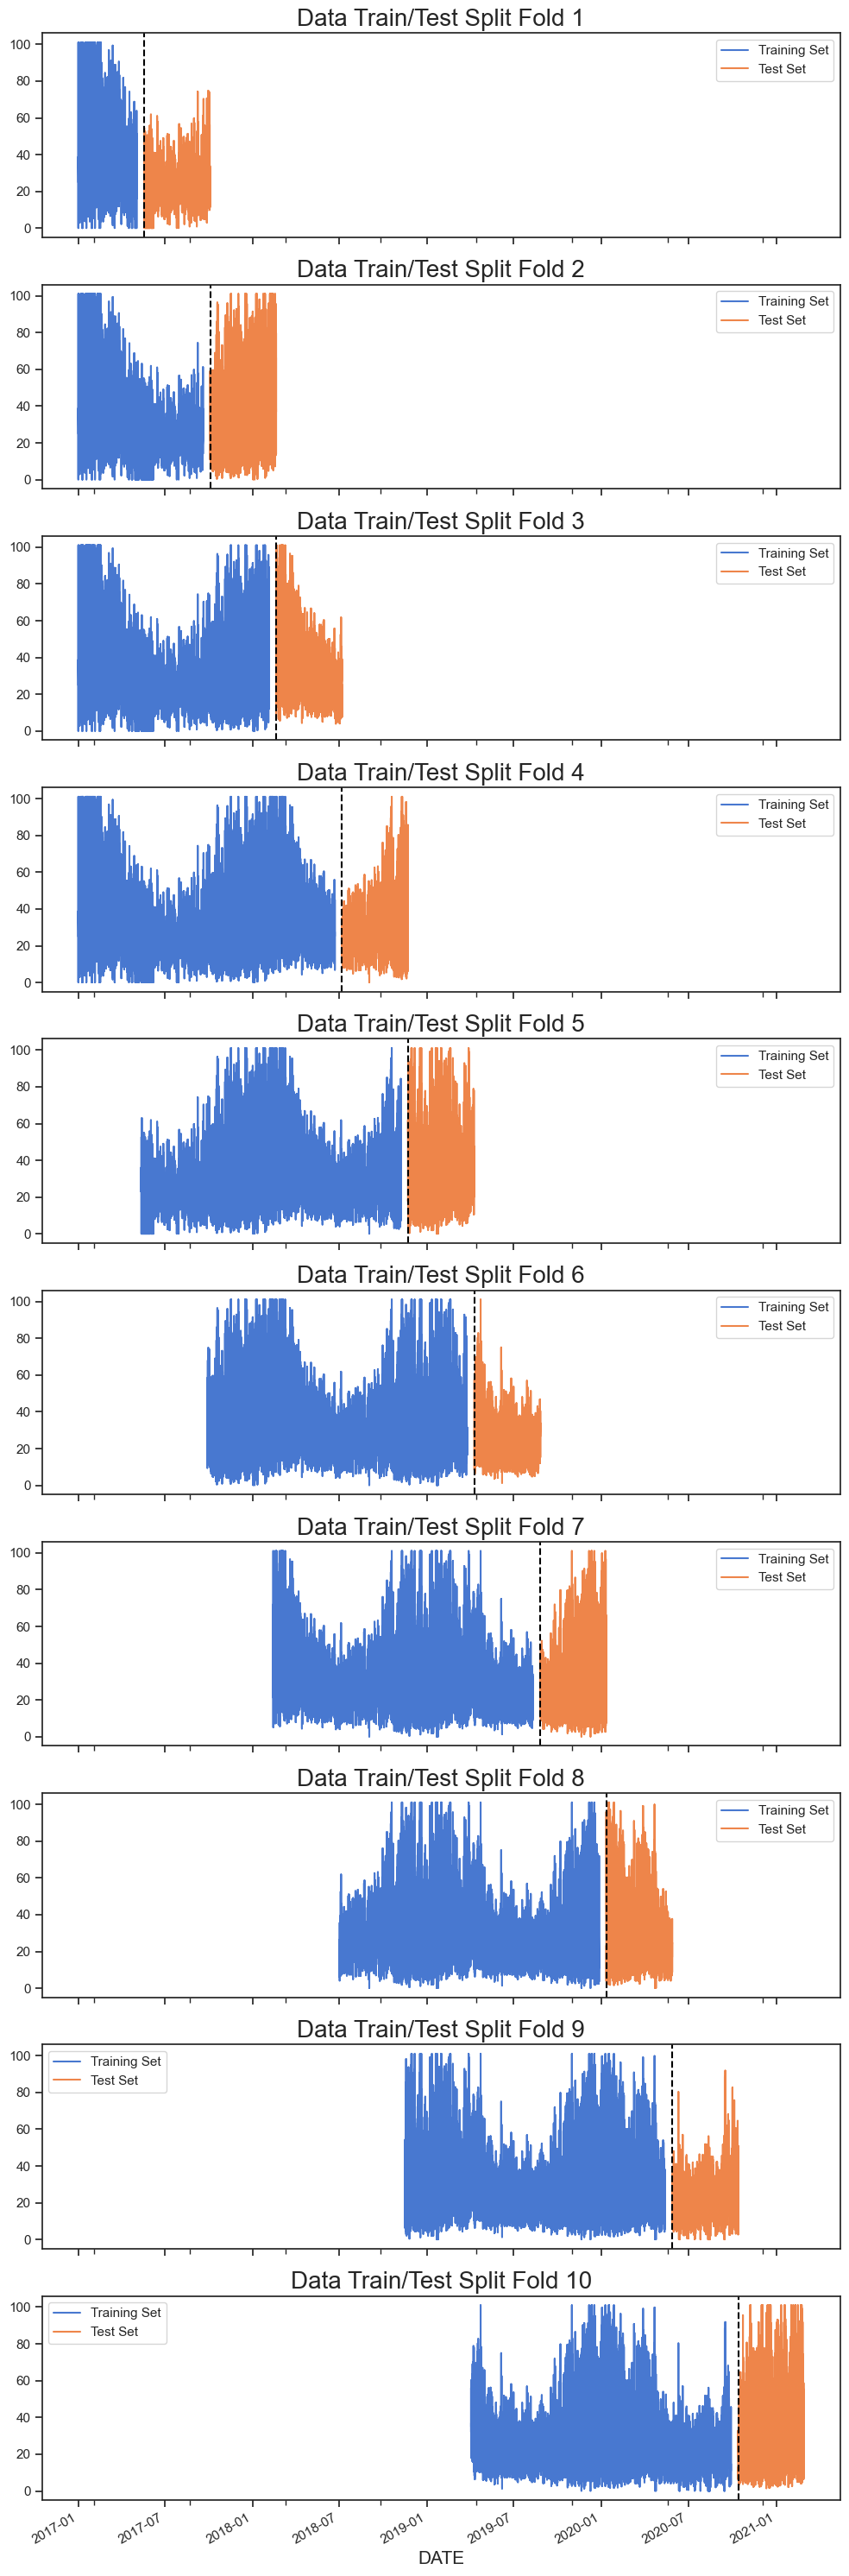

In [8]:
#Visualizing how the cross validation will be done
n_split = 10

# max_train_size=None
test_size=None

max_train_size=198*544
# test_size=198*60

tss = TimeSeriesSplit(
    n_splits=n_split, 
    max_train_size=max_train_size, 
    test_size=test_size, 
    gap=198*15
)

fig, axs = plt.subplots(n_split, 1, figsize=(10, n_split*3), sharex=True, tight_layout=True)

fold = 0
for train_idx, val_idx in tss.split(train):
    train_cv = train.iloc[train_idx]
    test_cv = train.iloc[val_idx]
    
    train_cv.plot(y='CAQI_idx', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold + 1}')
    
    test_cv.plot(y='CAQI_idx', ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
    fold += 1

In [9]:
%%time
#Training the pipeline using Cross validation
rmse_values = []

cv = 1
# Loop through the folds
print("Cross Validating.....")
print()

for train_index, test_index in tss.split(X_train, y_train):
       
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model on the train data
    pipeline.fit(X_train_cv, y_train_cv)

    # Predict on the test data
    y_pred = pipeline.predict(X_test_cv)
    
    # Calculate the mean squared error
    rmse = mean_squared_error(y_test_cv, y_pred, squared=False)
        
    print(f"cv #{cv}: RMSE = {rmse:.3f}")
    
    rmse_values.append(rmse)
    cv += 1

# Print the average MSE over all folds
print()
print(f"Average Train RMSE: {np.mean(rmse_values):.3f}")


#Predicting on Test set
predictions = pipeline.predict(X_test)
test_rmse = mean_squared_error(y_test, predictions, squared=False)

print(f"Test RMSE Score: {test_rmse:.3f}")
print()

Cross Validating.....

cv #1: RMSE = 5.960
cv #2: RMSE = 12.914
cv #3: RMSE = 8.983
cv #4: RMSE = 8.102
cv #5: RMSE = 12.154
cv #6: RMSE = 5.400
cv #7: RMSE = 9.803
cv #8: RMSE = 8.930
cv #9: RMSE = 5.330
cv #10: RMSE = 11.518

Average Train RMSE: 8.909
Test RMSE Score: 8.107

Wall time: 3min 20s


In [10]:
feat_scores=pipeline.steps[-1][-1].feature_importances_

#Creating a dataframe for feature importance
feat_imp_df = \
pd.DataFrame({
    'features' :encoders.fit_transform(X_train).columns,
    'importance' : np.round(feat_scores, 3)
}).set_index('features').sort_values('importance')

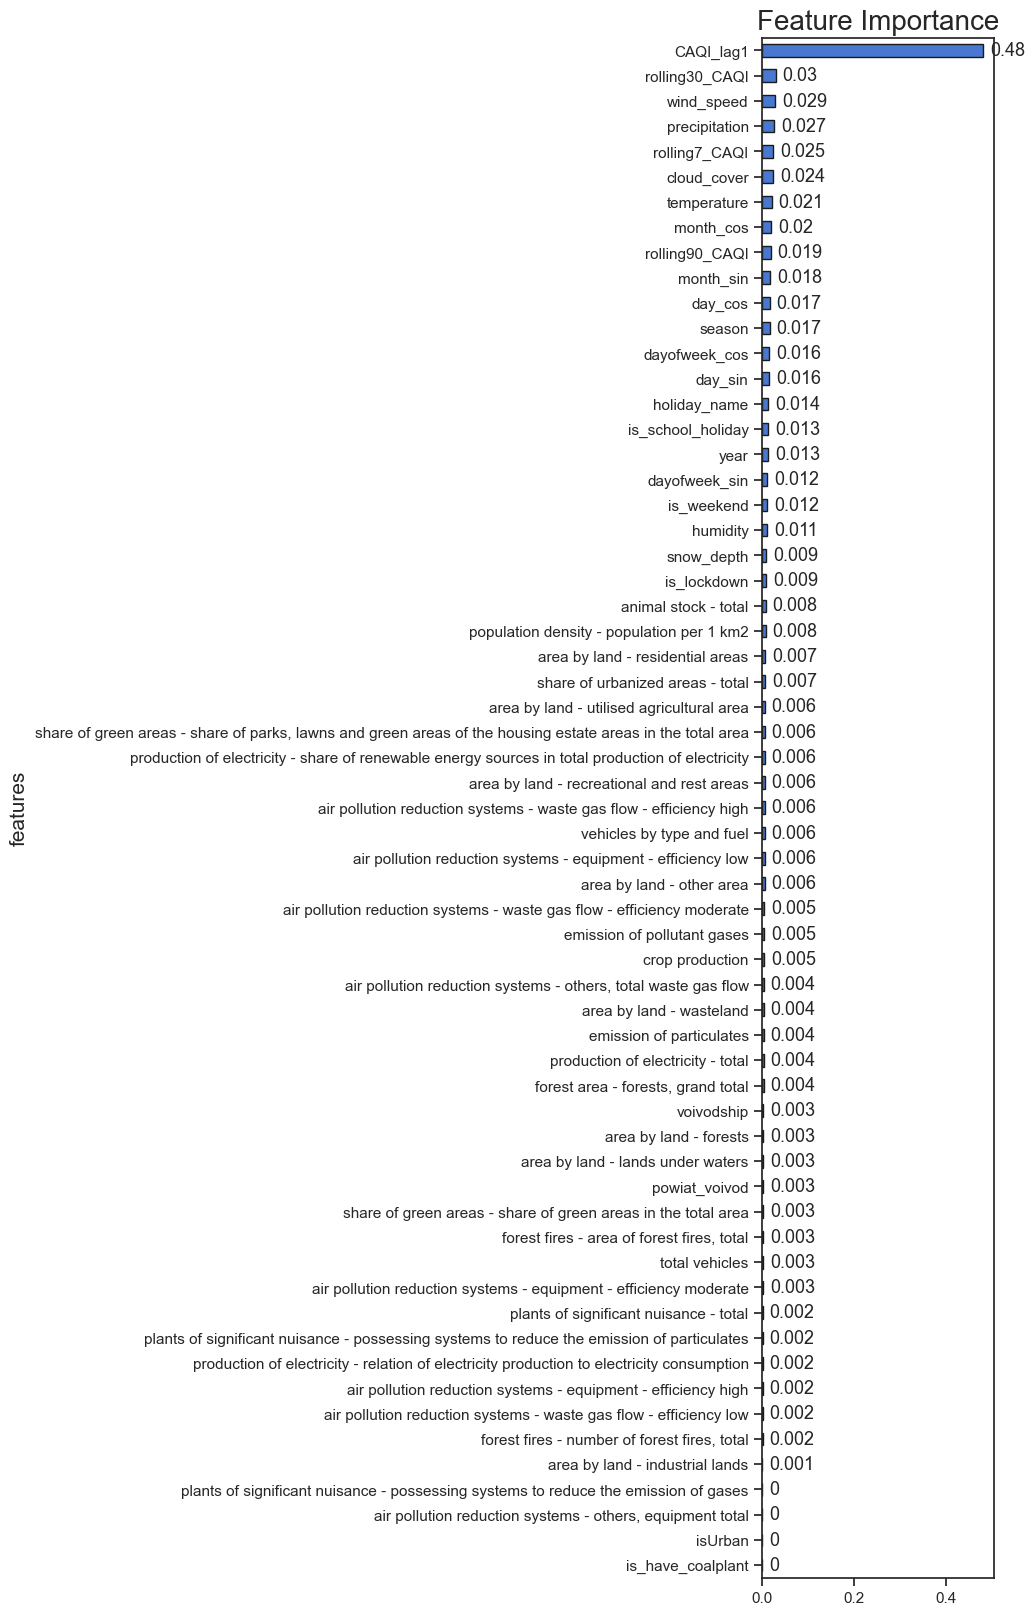

In [11]:
ax = feat_imp_df.plot(kind='barh', edgecolor='k', figsize=(3, 20))

ax.bar_label(ax.containers[0], fontsize = 13, padding = 5);
ax.legend().remove()
ax.set_title("Feature Importance");

In [12]:
np.sort(feat_imp_df.query("importance==0").index)

array(['air pollution reduction systems - others, equipment total',
       'isUrban', 'is_have_coalplant',
       'plants of significant nuisance - possessing systems to reduce the emission of gases'],
      dtype=object)

In [13]:
test_df = pd.concat([X_test[['powiat_voivod', 'voivodship']], y_test], axis=1)
test_df['predictions'] = predictions

test_df['error'] = test_df['CAQI_idx'] - test_df['predictions']

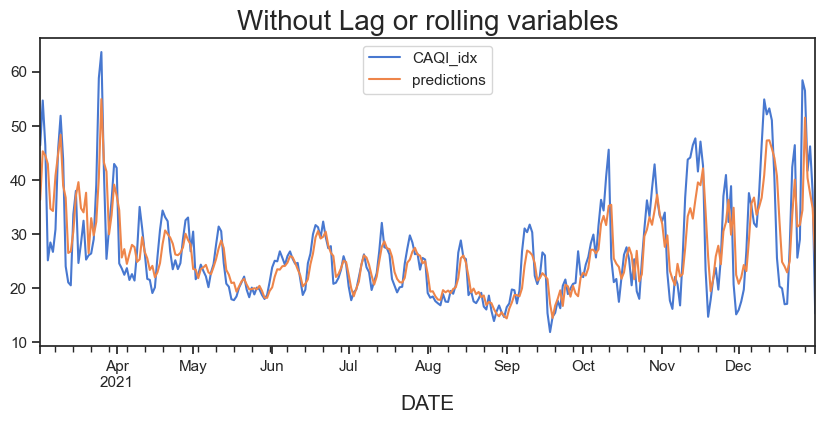

In [14]:
test_df.groupby(test_df.index)[['CAQI_idx', 'predictions']].mean().\
    plot(title='Without Lag or rolling variables', figsize=(10, 4));

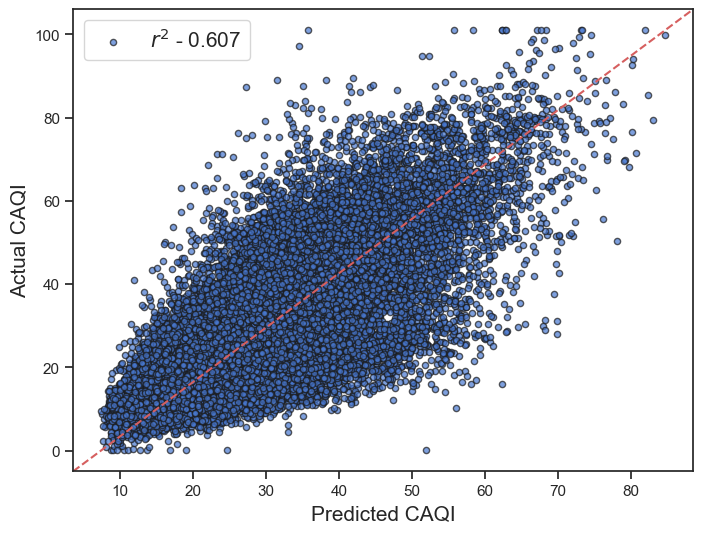

In [15]:
r2 = r2_score(test_df['CAQI_idx'], test_df['predictions'])

fig, ax = plt.subplots(figsize=(8, 6))

test_df.plot(x='predictions', y='CAQI_idx', kind='scatter', edgecolor='k', c='b', 
             alpha=0.7, ax=ax, label=f"$r^2$ - {r2:.3f}");

ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='r', ls='--')  

ax.legend(fontsize=15)
ax.set_ylabel("Actual CAQI")
ax.set_xlabel("Predicted CAQI");

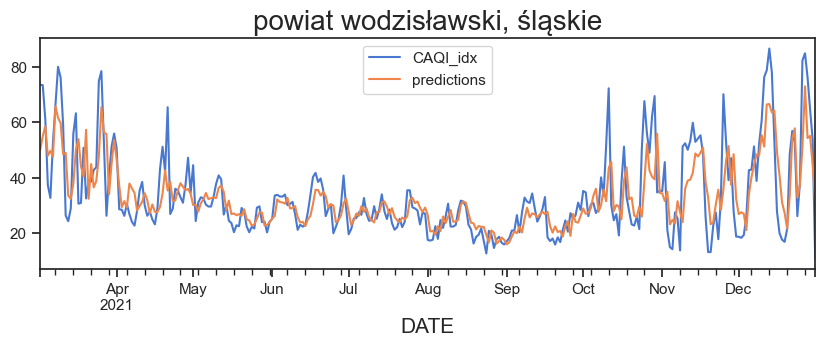

In [16]:
#Powiat with highest mean CAQI
ax = test_df.query("powiat_voivod=='powiat wodzisławski, śląskie'").\
    plot(y=["CAQI_idx", "predictions"], figsize=(10, 3))

ax.set_title("powiat wodzisławski, śląskie");

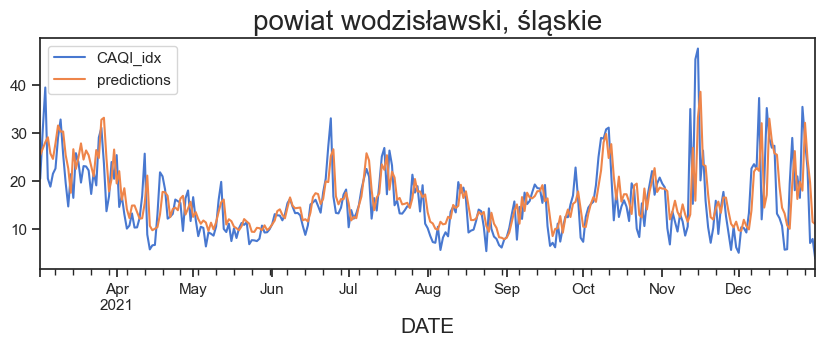

In [17]:
#Powiat with lowest mean CAQI
ax = test_df.query("powiat_voivod=='powiat krośnieński, podkarpackie'").\
    plot(y=["CAQI_idx", "predictions"], figsize=(10, 3))

ax.set_title("powiat wodzisławski, śląskie");